## Bayesian Linear Regression
Ilyas Ustun

In [62]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt
# import seaborn as sns

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")


Running on PyMC3 v3.11.1
Running on ArviZ v0.11.2


In [2]:
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")



We will work on a simple Bayesian linear regression model with normal priors for the parameters. We are interested in predicting outcomes Y as normally-distributed observations with an expected value μ that is a linear function of two predictor variables, X1 and X2.

$$
\begin{split}\begin{aligned}
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2
\end{aligned}\end{split}
$$


where α
is the intercept, and $β_i$ is the coefficient for covariate $X_i$, while σ represents the observation error. 

Since we are constructing a Bayesian model, we must assign a **prior distribution** to the unknown variables in the model. We choose zero-mean normal priors with variance of 100 for both regression coefficients, which corresponds to weak information regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for σ.


$$
\begin{split}\begin{aligned}
\alpha &\sim \mathcal{N}(0, 100) \\
\beta_i &\sim \mathcal{N}(0, 100) \\
\sigma &\sim \lvert\mathcal{N}(0, 1){\rvert}
\end{aligned}\end{split}
$$

## Create Data

In [3]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(size) * sigma



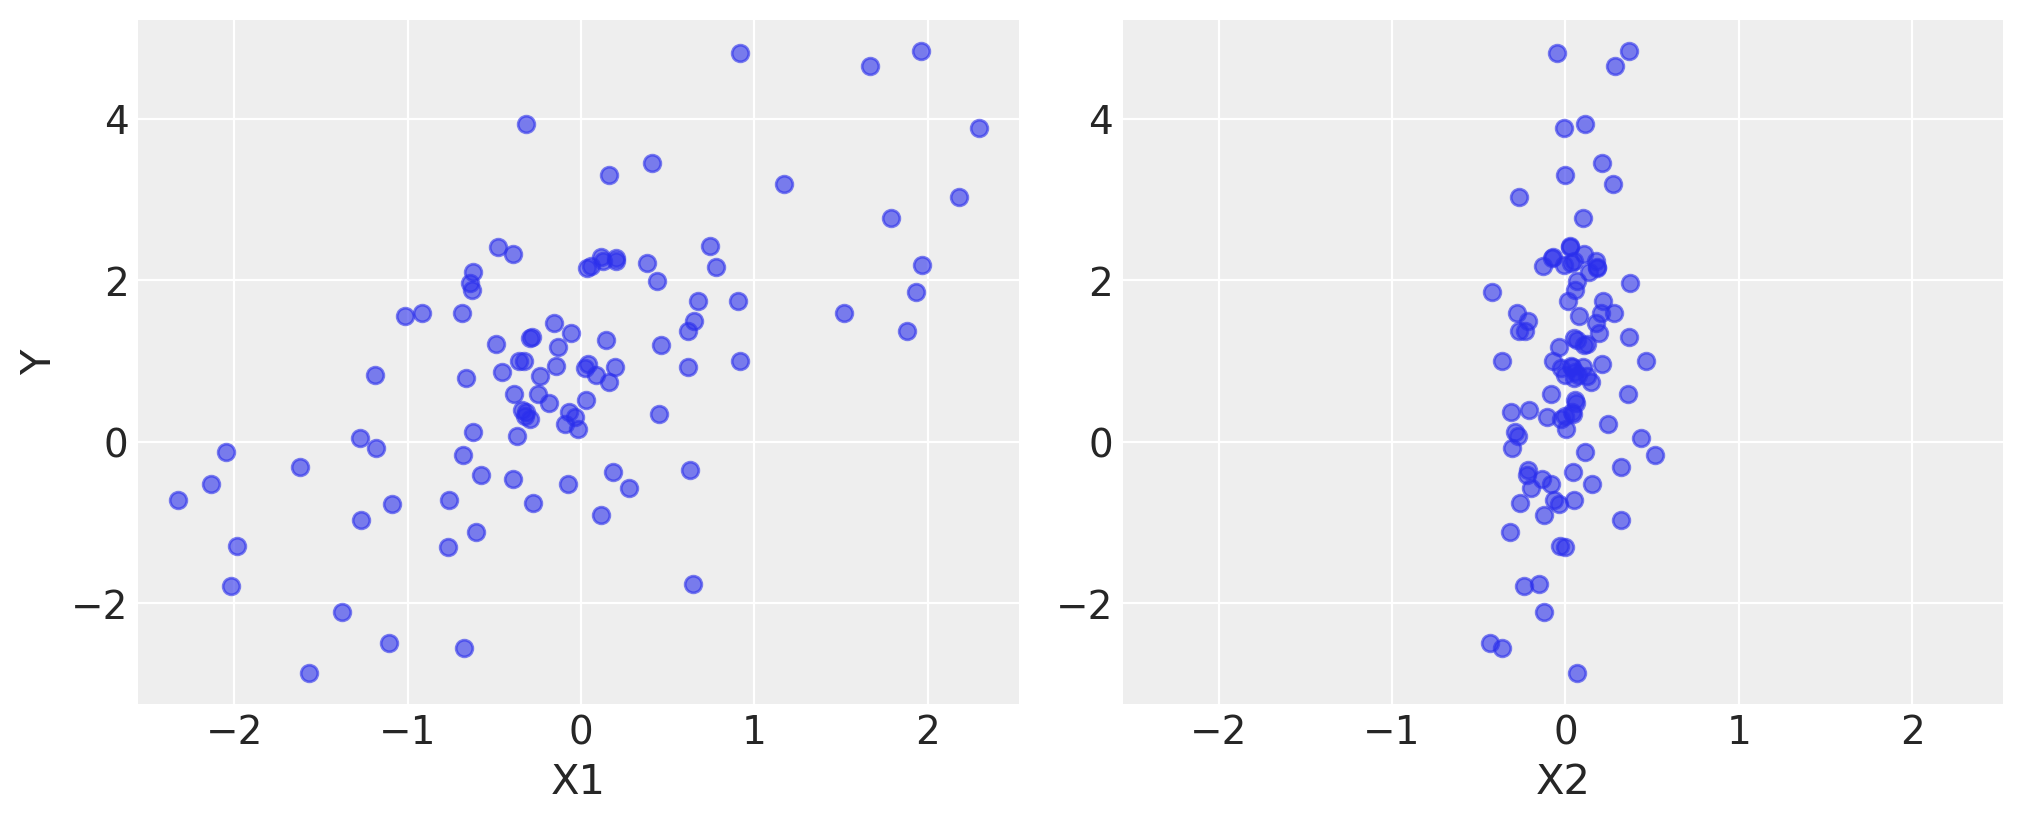

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [5]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    
    # Set shape to 2 because we have beta_1 and beta_2
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)



### Maximum a posteriori (MAP)
- The maximum a posteriori (MAP) estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods.  
- This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution

In [6]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'alpha': array(0.95724679),
 'beta': array([1.10071814, 2.9511438 ]),
 'sigma_log__': array(0.03540151),
 'sigma': array(1.0360356)}

### Sampling methods¶

- Though finding the MAP is a fast and easy way of obtaining estimates of the unknown model parameters, it is limited because there is no associated estimate of **uncertainty** produced with the MAP estimates. 
- Instead, a simulation-based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from samples from the true posterior distribution.

- To conduct MCMC sampling to generate posterior samples in PyMC3, we specify a step method object that corresponds to a particular MCMC algorithm, such as Metropolis, Slice sampling, or the No-U-Turn Sampler (NUTS). 
- PyMC3’s step_methods submodule contains the following samplers: NUTS, Metropolis, Slice, HamiltonianMC, and BinaryMetropolis. 
- These step methods can be assigned manually, or assigned automatically by PyMC3. 
- Auto-assignment is based on the attributes of each variable in the model. 
- In general:

    - Binary variables will be assigned to BinaryMetropolis

    - Discrete variables will be assigned to Metropolis

    - Continuous variables will be assigned to NUTS


In [8]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()
    
    # draw 500 posterior samples
    trace = pm.sample(500, step=step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 20 seconds.


In [9]:
trace

<MultiTrace: 4 chains, 500 iterations, 4 variables>

In [10]:
trace['alpha'][-5:]

array([0.96315478, 1.055312  , 1.24662085, 0.83794263, 0.86392036])

In [11]:
trace['beta'][-5:]

array([[1.23144385, 3.43445796],
       [1.17667092, 3.00821154],
       [0.98800921, 3.25819579],
       [1.08880033, 3.12483526],
       [1.18761975, 2.66919549]])

In [12]:
trace["sigma"][-5:]

array([1.08351824, 0.95525598, 0.97116843, 1.01367768, 1.01975295])

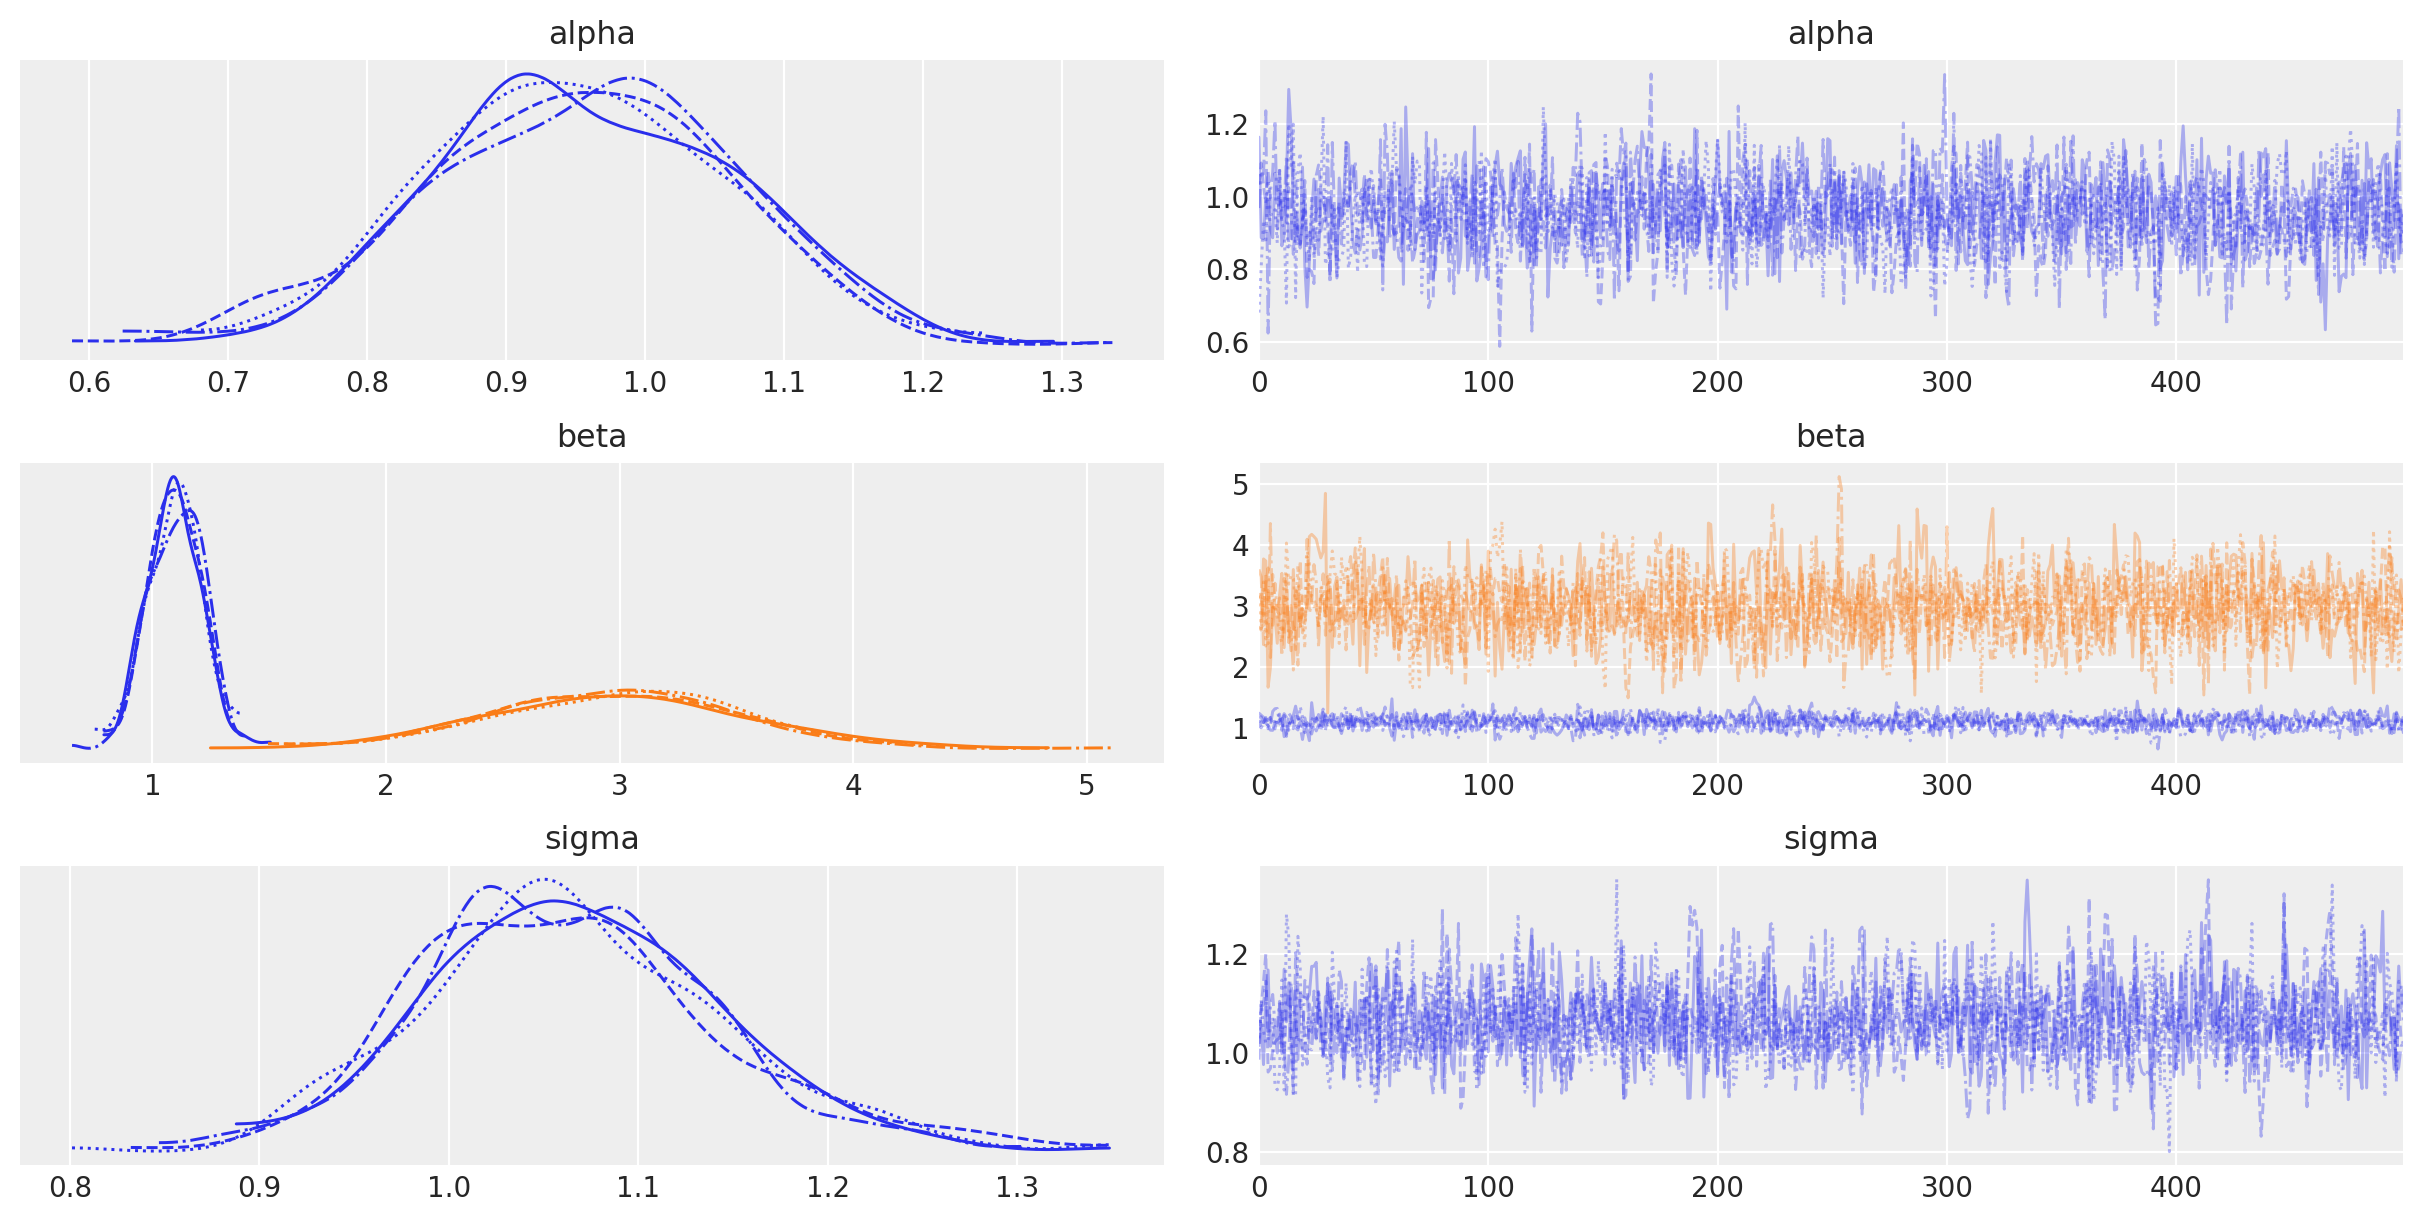

In [18]:
with basic_model:
    az.plot_trace(trace, combined=False);

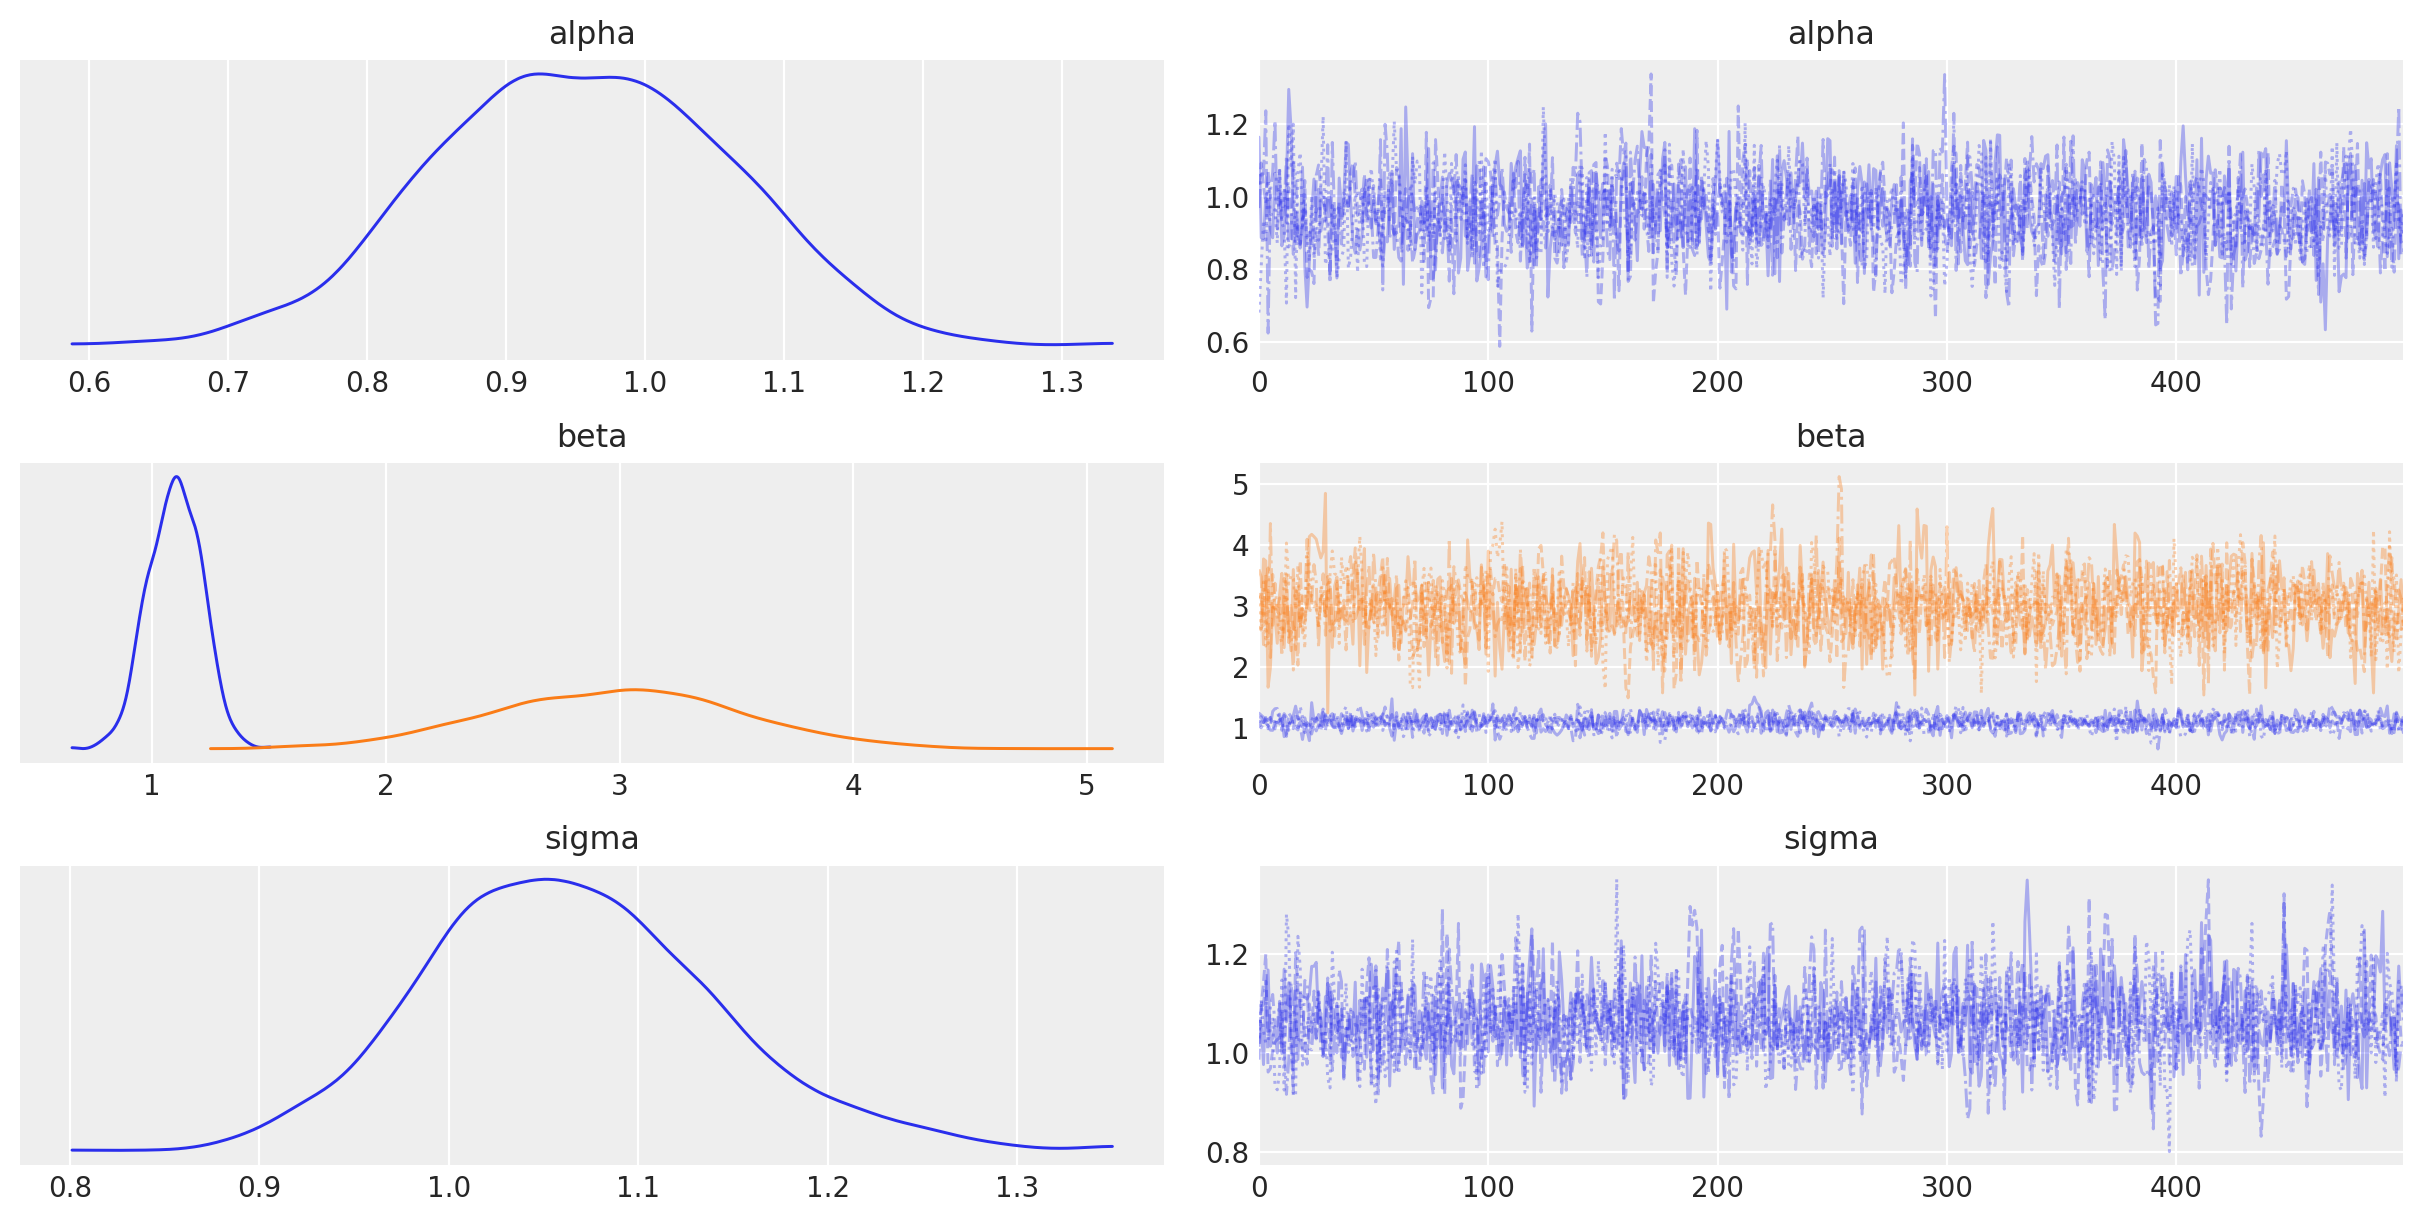

In [17]:
with basic_model:
    az.plot_trace(trace, combined=True);

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order.

In [31]:
with basic_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.95,0.11,0.77,1.16,0.00,0.00,1855.64,1679.90,1.0
beta[0],1.10,0.11,0.90,1.31,0.00,0.00,1896.49,1275.76,1.0
beta[1],2.99,0.53,1.96,3.97,0.01,0.01,1729.72,1124.03,1.0
sigma,1.06,0.08,0.92,1.21,0.00,0.00,1882.73,1494.19,1.0


### Predictions

In [29]:
# with basic_model:
#     az.plot_posterior(trace)

In [32]:
predictions = pm.sample_posterior_predictive(trace, model=basic_model)

In [36]:
predictions

{'Y_obs': array([[-1.10998906,  0.23880999,  1.833574  , ..., -2.13044287,
          0.90956216,  0.55524666],
        [ 2.55747833, -0.53085051,  2.52370931, ..., -0.42754035,
          1.34831773,  1.69025472],
        [ 0.98240861,  1.12022846,  1.9988925 , ...,  0.39892187,
          0.73001235,  1.8861357 ],
        ...,
        [ 0.86851021,  2.00538545,  3.2959116 , ..., -0.56399919,
          4.13763855,  1.59643912],
        [-0.13424636,  0.24361397,  0.83848002, ..., -2.70315743,
          0.50402675,  0.76355938],
        [-0.35832894, -0.50766233,  2.01138732, ..., -2.49737255,
          2.39697374, -0.38440235]])}

In [37]:
predictions['Y_obs']

array([[-1.10998906,  0.23880999,  1.833574  , ..., -2.13044287,
         0.90956216,  0.55524666],
       [ 2.55747833, -0.53085051,  2.52370931, ..., -0.42754035,
         1.34831773,  1.69025472],
       [ 0.98240861,  1.12022846,  1.9988925 , ...,  0.39892187,
         0.73001235,  1.8861357 ],
       ...,
       [ 0.86851021,  2.00538545,  3.2959116 , ..., -0.56399919,
         4.13763855,  1.59643912],
       [-0.13424636,  0.24361397,  0.83848002, ..., -2.70315743,
         0.50402675,  0.76355938],
       [-0.35832894, -0.50766233,  2.01138732, ..., -2.49737255,
         2.39697374, -0.38440235]])

In [35]:
predictions['Y_obs'].shape

(2000, 100)

In [43]:
means = az.summary(trace, round_to=4)['mean']
means

alpha      0.9546
beta[0]    1.0976
beta[1]    2.9872
sigma      1.0645
Name: mean, dtype: float64

In [72]:
alpha = trace[200:]['alpha'].mean()
alpha

0.9524422924429742

In [73]:
betas = trace[200:]['beta'].mean(axis=0)
betas

array([1.09907054, 2.99101761])

In [74]:
data = [X1, X2]
data

[array([-0.29143213, -1.27033081,  0.91979879,  2.29447325, -0.338979  ,
        -1.37764807,  2.17794384, -2.13254124,  0.45146367,  0.1294516 ,
        -0.32948615, -0.3897104 ,  1.96706129,  0.78099003,  0.06009008,
        -0.06049997, -0.35478013,  0.673507  ,  0.08672537,  0.20135155,
         0.90553869, -0.6402238 , -0.23383385, -0.3143203 ,  0.6481792 ,
         0.1174869 ,  0.40834446, -0.28266957, -0.62516674,  0.6186118 ,
        -0.47779753, -0.18357456, -0.68219961,  0.38226964, -0.67365314,
        -0.3676752 ,  0.74261167, -0.09074299, -0.14670081, -1.09032818,
        -0.76910614,  0.46133259, -0.63048839, -1.27550124,  1.88205622,
         1.93472161, -2.04716187, -0.45390819,  1.79029219,  0.27692083,
         0.02126023, -1.61958632, -0.13282915,  0.43610936, -0.60380005,
        -0.7584952 , -0.29310951, -0.27606762,  0.14461565,  0.0285069 ,
         0.91795676, -0.62268638,  0.62628431,  1.6676557 ,  0.19424813,
         0.18642781, -1.18238145, -0.24537438, -0.6

In [75]:
predictions = alpha + np.dot(betas, [X1, X2])

predictions

array([ 0.78795559,  0.50648001,  1.81524929,  3.45413849, -0.05238539,
       -0.9356736 ,  2.54445924, -0.94133863,  1.58322956,  1.23740491,
        0.37795565,  0.12375557,  3.08726287,  2.34783206,  0.63545157,
        1.4676926 ,  1.94698275,  1.73584519,  1.0347573 ,  1.69407976,
        2.60007686,  1.3569007 ,  1.06245908, -0.33741831,  1.21458866,
        0.86414932,  2.02330218,  1.73436906, -0.59705658,  0.82550865,
        0.50743173,  0.93179182,  1.74622974,  1.46200915, -0.87830304,
       -0.26746648,  1.84017081,  1.58685649,  0.89453443, -0.34936442,
        0.10385605,  1.78557009,  0.41712571,  0.84949255,  2.31684482,
        1.80822553, -0.96827932,  0.6107097 ,  3.22360743,  0.66214624,
        0.89979455,  0.13331916,  0.68736818,  1.62820889, -0.67314428,
       -0.07877108,  0.55895197, -0.14088526,  1.30970262,  1.15264946,
        0.86038075,  0.66886646,  0.99018301,  3.63732455,  1.27582172,
        1.29351009, -1.26524376,  0.43106579,  0.37917405,  0.07

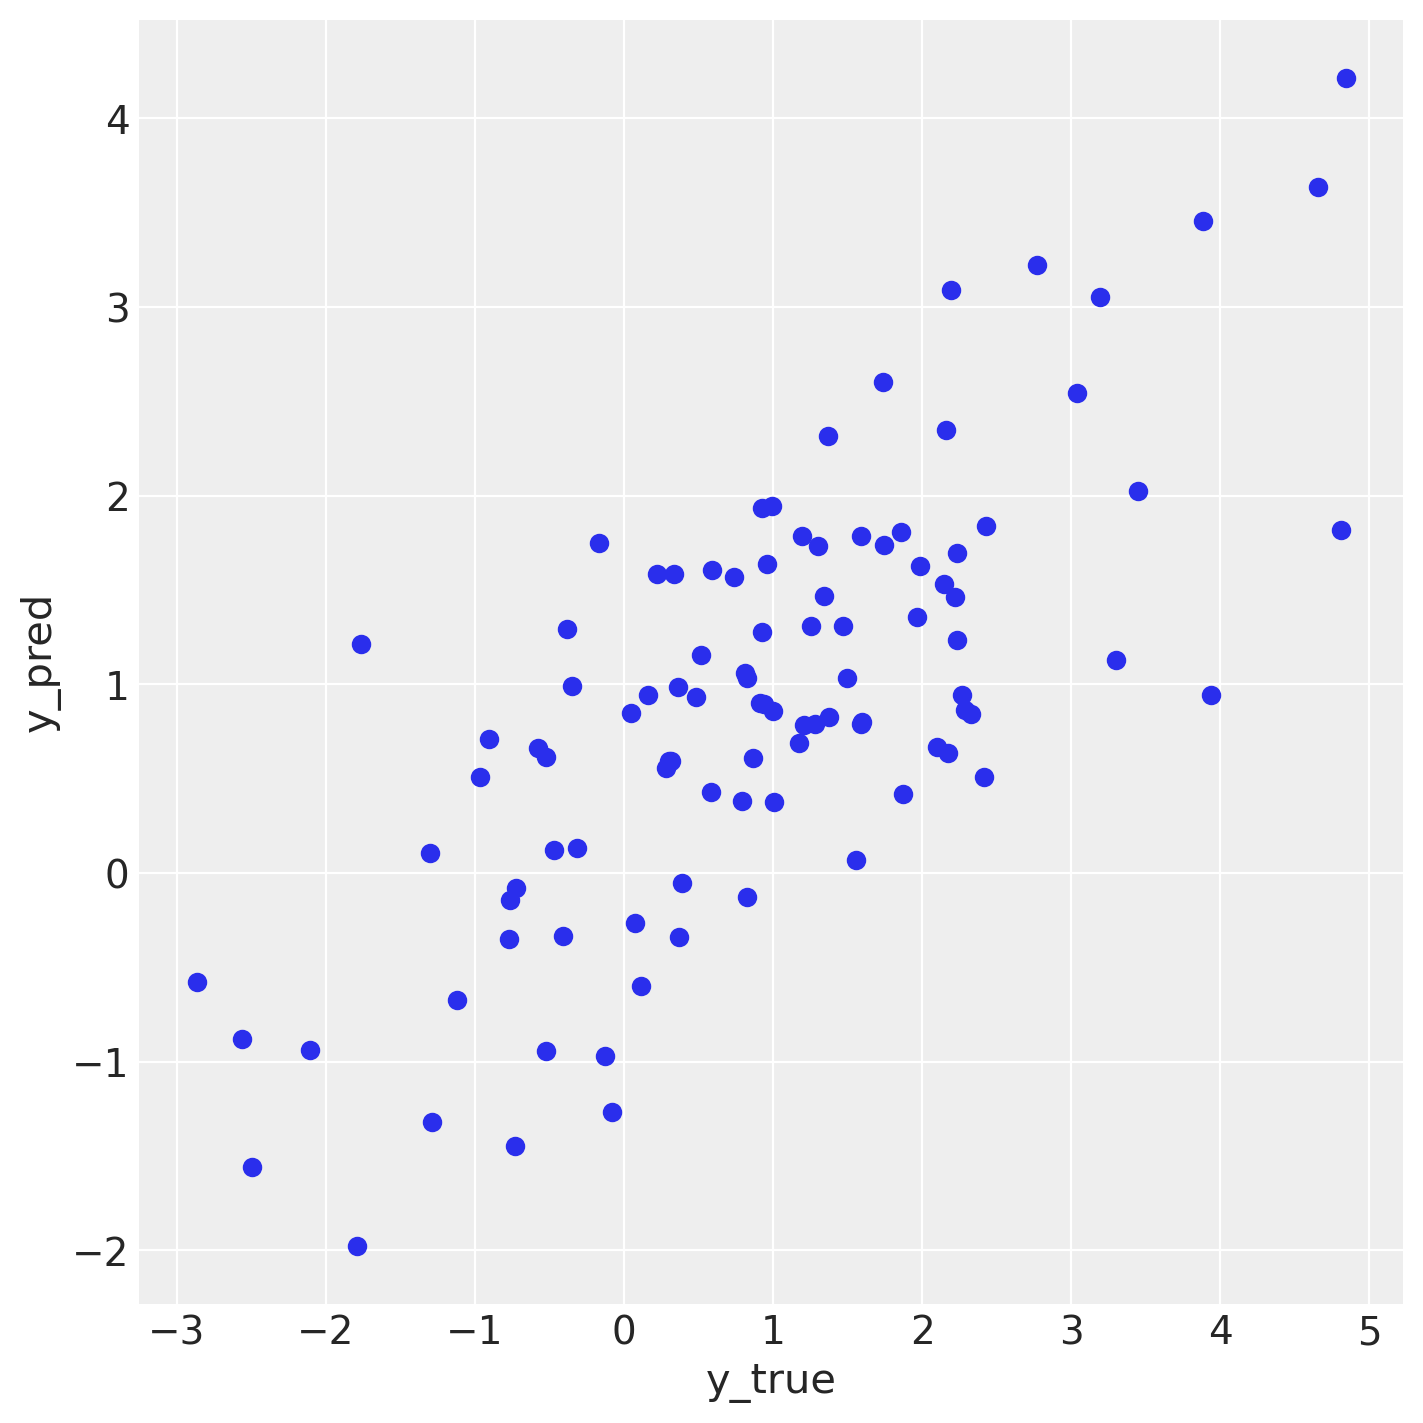

In [76]:
plt.figure(figsize=(7, 7))
plt.plot(Y, predictions, 'o', label='data')
plt.xlabel('y_true')
plt.ylabel('y_pred');

Adapted from: https://docs.pymc.io/notebooks/getting_started